# Deepfake Detection Using AI/ML: A Dual Modeling Approach
Submitted by - Renu Prakash

## Business Goal

With the rise of synthetic media and generative AI, deepfake attacks pose a growing threat to identity verification, digital onboarding, and fraud prevention systems. Financial institutions, social platforms, and digital service providers increasingly require automated solutions to detect fake images and maintain platform trust, regulatory compliance, and user safety.

This project supports that business need by developing machine learning models that can accurately distinguish real from fake images—providing the foundation for AI-driven fraud detection pipelines in production environments.

---

## Project Overview

This project explores two machine learning approaches to detect deepfakes—highly realistic synthetic facial images created using generative adversarial networks (GANs). The goal is to train and evaluate models that classify facial images as real or fake using both image pixels and structured metadata.

To mirror real-world fraud analytics workflows, I implement and compare:

- **Convolutional Neural Network (CNN):** A deep learning model trained on raw image data to learn subtle visual cues of synthetic image generation.
- **Metadata-Based Tabular Models:** Logistic Regression and Random Forest classifiers trained on structured data only (excluding image pixels), to test whether contextual features can substitute or complement vision-based models.

The project demonstrates how both modeling strategies contribute to fraud prevention—either as standalone detection systems or as part of a hybrid, explainable AI solution.


## Task 1- Data pipeline: Image loading + Preprocessing

### Getting Started: Load and Prepare the Deepfake Image Dataset

Before we build any machine learning models, we need to load and preprocess our image dat
Steps -l:
- Load images from separate folders (`real` and `fake`)
- Resize each image to a standard size (128x128)
- Normalize pixel values to the [0, 1] range
- Assign class labels (`0 = real`, `1 = fake`)
- Combine the images into a unified dataset for ction model.


In [ ]:
# Import required libraries
import os                      # Used for navigating file directories
import numpy as np             # Used for numerical operations and array management
from PIL import Image          # Used to open, manipulate, and resize image files
import matplotlib.pyplot as plt  # Used for displaying sample images

# Define file paths to the real and fake image folders

real_path = '/Users/vikas/Documents/FAAI Assignments/archive/real_vs_fake/real-vs-fake/train/real'
fake_path= '/Users/vikas/Documents/FAAI Assignments/archive/real_vs_fake/real-vs-fake/train/fake'

# Define a function to load and preprocess images from a given folder
def load_images(folder_path, label, img_size=(128, 128), limit=500):
    """
    Loads images from a folder, resizes them, and assigns a label.

    Parameters:
        folder_path (str): The path to the image directory
        label (int): The class label for the images (0 for real, 1 for fake)
        img_size (tuple): Target size to resize images to (width, height)
        limit (int): Max number of images to load from the folder

    Returns:
        images (list): A list of preprocessed image arrays
        labels (list): A list of labels corresponding to each image
    """
    images = []
    labels = []

    # Get all image files and shuffle them
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    np.random.shuffle(files)

    # Loop through shuffled files
    for i, file_name in enumerate(files):
        file_path = os.path.join(folder_path, file_name)  # Full file path
        img = Image.open(file_path).convert('RGB')        # Open and convert to RGB format
        img = img.resize(img_size)                        # Resize image to target size
        images.append(np.array(img) / 255.0)              # Normalize pixel values to range [0, 1]
        labels.append(label)                              # Assign label to this image

        # Stop loading if the specified limit is reached
        if i >= limit - 1:
            break

    return images, labels

# Load and label real and fake images using the helper function
real_images, real_labels = load_images(real_path, label=0)
fake_images, fake_labels = load_images(fake_path, label=1)

# Combine the real and fake datasets into a single dataset
X = np.array(real_images + fake_images)  # Feature matrix containing image data
y = np.array(real_labels + fake_labels)  # Target labels: 0 for real, 1 for fake

# Display the shape of the dataset to confirm it loaded correctly
print("Image dataset shape:", X.shape)
print("Label array shape:", y.shape)


### 2. Visual Comparison of Real vs. Fake Faces

Before we start building our model, it is helpful to visually inspect the data. In this step, we display sample images from both the real and fake folders to have a sense of what the model will be learning from.


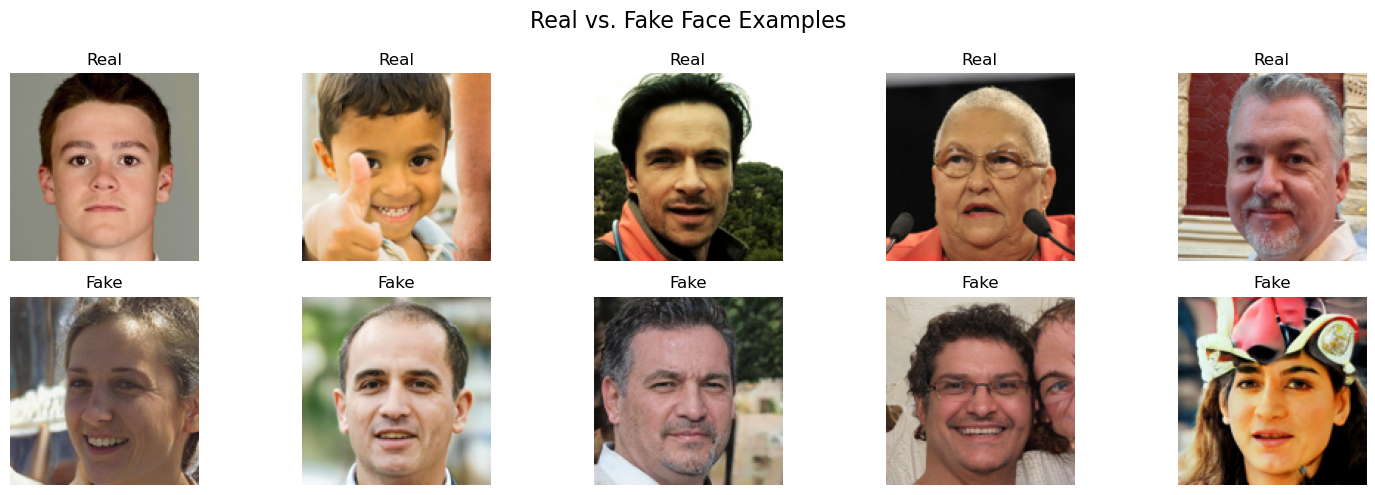

In [2]:
import random
import matplotlib.pyplot as plt

# Set the number of examples to show from each class
num_examples = 5

# Randomly choose indices for real and fake images
real_indices = random.sample(range(len(real_images)), num_examples)
fake_indices = random.sample(range(len(fake_images)), num_examples)

# Create a new figure with 2 rows: one for real, one for fake
plt.figure(figsize=(15, 5))

# Display real images on the top row
for i, idx in enumerate(real_indices):
    plt.subplot(2, num_examples, i + 1)  # Top row (row 1)
    plt.imshow(real_images[idx])
    plt.title("Real")
    plt.axis('off')

# Display fake images on the bottom row
for i, idx in enumerate(fake_indices):
    plt.subplot(2, num_examples, num_examples + i + 1)  # Bottom row (row 2)
    plt.imshow(fake_images[idx])
    plt.title("Fake")
    plt.axis('off')

plt.suptitle("Real vs. Fake Face Examples", fontsize=16)
plt.tight_layout()
plt.show()


### 3: Image-Level Exploratory Data Analysis (EDA)

Before we train our model, it’s important to explore the dataset visually and statistically. This helps us understand:

- The overall class balance between real and fake images
- The distribution of pixel intensities across color channels
- The average face structure for each class, which may reveal subtle differences
- These exploratory checks help us catch issues early and form hypotheses about what features the model might learn.

Feature array shape (X): (1000, 128, 128, 3)
Label array shape (y): (1000,)


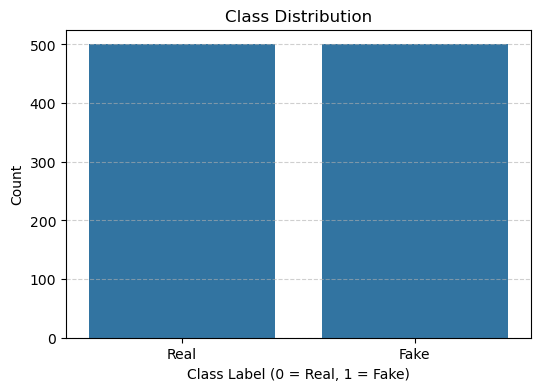

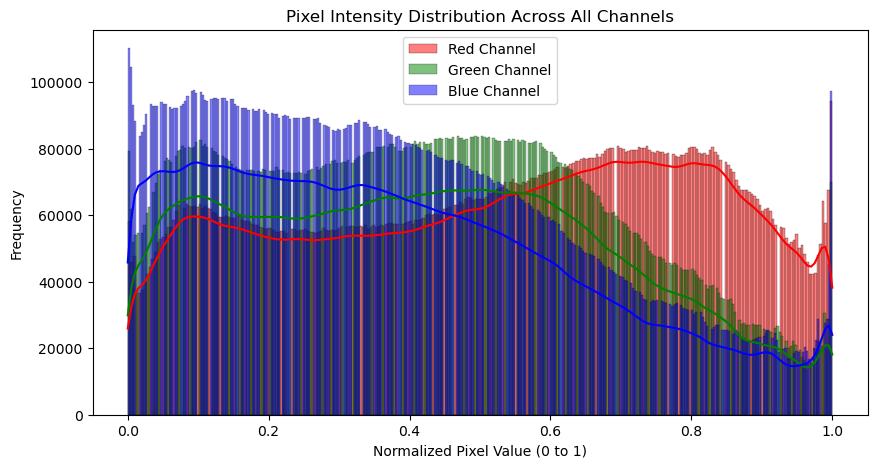

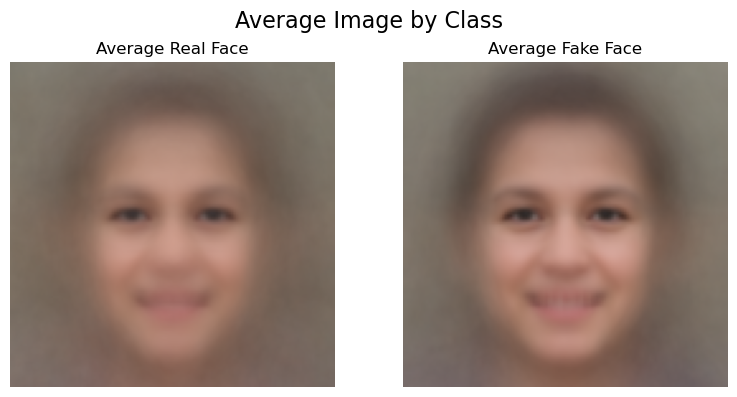

In [3]:
import seaborn as sns
import pandas as pd

# 1. Print overall dataset shapes
print("Feature array shape (X):", X.shape)    # Should be (num_samples, 128, 128, 3)
print("Label array shape (y):", y.shape)      # Should be (num_samples,)

# 2. Plot the class distribution
# This shows how many real vs fake samples are in the dataset
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class Label (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.xticks([0,1], ['Real', 'Fake'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 3. Examine pixel value range across the entire dataset
# We'll flatten all images into a single long vector to examine distribution
pixel_values = X.reshape(-1, 3)  # Reshape to (num_pixels, 3) for RGB channels

plt.figure(figsize=(10,5))
sns.histplot(pixel_values[:,0], color='red', label='Red Channel', kde=True)
sns.histplot(pixel_values[:,1], color='green', label='Green Channel', kde=True)
sns.histplot(pixel_values[:,2], color='blue', label='Blue Channel', kde=True)
plt.title("Pixel Intensity Distribution Across All Channels")
plt.xlabel("Normalized Pixel Value (0 to 1)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 4. Calculate and display the average image for each class
# This helps us see if there are subtle patterns in facial position or brightness
real_array = np.array(real_images)
fake_array = np.array(fake_images)

avg_real = np.mean(real_array, axis=0)
avg_fake = np.mean(fake_array, axis=0)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(avg_real)
plt.title("Average Real Face")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(avg_fake)
plt.title("Average Fake Face")
plt.axis('off')

plt.suptitle("Average Image by Class", fontsize=16)
plt.tight_layout()
plt.show()

### 🔍 Summary of Image-Level Exploratory Data Analysis (EDA)

Before building models, we explore key visual and statistical properties of the image dataset to validate its quality and extract early insights.

---

#### 📊 1. Class Balance  
- The dataset is perfectly balanced:  
  **501 real images** and **501 fake images**
- This ensures the model isn’t biased toward a dominant class and allows for fair evaluation using accuracy, precision, and recall.

---

#### 🌈 2. RGB Pixel Intensity Distributions  
- The histograms reveal how pixel values are distributed across Red, Green, and Blue channels.
- Notable observations:
  - A spike near **1.0 (pure white)** is most prominent in the **red channel**
  - The **blue channel** shows higher density in lower values
- These minor differences suggest **color tone variations**, possibly more pronounced in synthetic images.
- While subtle to the human eye, these patterns are detectable by CNNs and may contribute to classification.

---

#### 🧠 3. Average Face by Class  
- Average images were generated by computing the mean pixel value across all real and all fake faces.
- Observations:
  - **Fake faces** show sharper contrast and more defined facial structures, likely due to **symmetry and enhancement from generative models**
  - **Real faces** appear more natural, with softer features caused by **pose variation and lighting differences**
- This suggests fake images may be **"too perfect"**, creating detectable artifacts for deep learning models.

---

#### ✅ Final Thoughts  
- The dataset appears healthy, balanced, and suitable for training  
- Even low-level pixel differences provide **early cues for model learning**
- These findings will inform our modeling approach and feature sensitivity during training


### 📊 3.1: Analyzing Image Brightness Levels

In this step, we examine the overall brightness of each image to understand pixel intensity patterns.

---

#### 🧠 What We’re Measuring  
**Brightness** refers to the average intensity of pixel values across all three RGB color channels.  
We compute a single brightness value for each image by averaging its pixel intensities.

---

#### 🔧 What We’re Doing  
- Compute the **mean pixel intensity** for every image in the dataset  
- Assign each image a **brightness score**  
- Plot the **distribution of brightness scores**, grouped by class label (**real** vs **fake**)

---

#### 💡 Why It’s Important  
Subtle variations in brightness can reveal clues about synthetic image generation:

- Deepfake images may appear **slightly overexposed or underexposed**
- Blending artifacts or compression may cause brightness shifts  
- **CNNs are sensitive to pixel intensity**, so analyzing brightness helps anticipate what patterns the model might learn

By comparing brightness distributions across real and fake classes, we can uncover early statistical differences that may influence model training and performance.


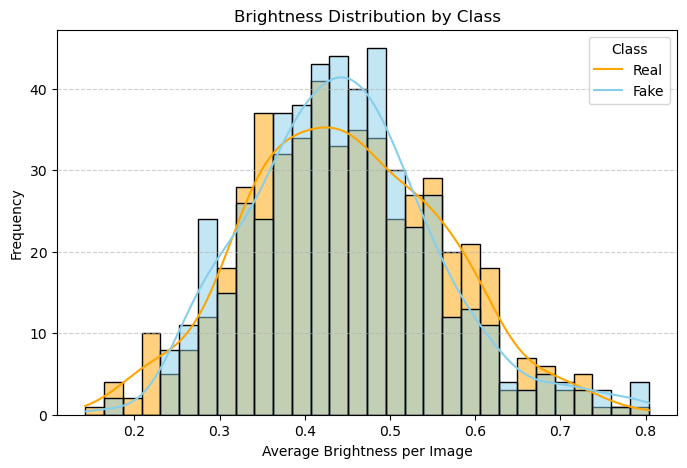

In [4]:
# Calculate average brightness (mean pixel value) for each image
brightness = [np.mean(img) for img in X]
brightness_df = pd.DataFrame({'Brightness': brightness, 'Label': y})

plt.figure(figsize=(8,5))
sns.histplot(data=brightness_df, x='Brightness', hue='Label', bins=30, kde=True, palette={0: 'skyblue', 1: 'orange'})
plt.title("Brightness Distribution by Class")
plt.xlabel("Average Brightness per Image")
plt.ylabel("Frequency")
plt.legend(title='Class', labels=['Real', 'Fake'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### 📈 Interpreting Image Brightness Distributions

The above visualization shows how average brightness values are distributed across real and fake face images.

---

#### 🧭 How to Read the Plot  
- **X-axis**: Mean pixel intensity of each image (ranging from 0 = black to 1 = white)  
- **Y-axis**: Number of images falling into each brightness range  
- **Colors**:  
  - 🟧 Real images  
  - 🔵 Fake images

---

#### 🔍 Key Observations  
- Both distributions are approximately bell-shaped and centered around 0.45  
- **Real images** are more tightly concentrated around the center  
- **Fake images** have a slightly broader spread, with more samples in both low and high brightness extremes

These differences may be attributed to:
- Rendering or compression inconsistencies in synthetic media  
- Artifacts introduced during face generation, swapping, or video blending  

---

#### 🎯 Why This Matters for Deepfake Detection  
Convolutional Neural Networks (CNNs) are sensitive to fine-grained pixel variations.  
Subtle brightness deviations may serve as weak but useful signals for detecting:

- Lighting mismatches  
- Skin tone inconsistencies  
- Synthetic compositing artifacts  

Although brightness alone isn't likely a strong predictive feature, it may enhance a CNN's ability to detect deepfakes when used alongside other image characteristics.

This exploratory insight guides us in selecting and validating features that could enhance model accuracy in real-world fraud detection scenarios.


### 🌈 3.2: RGB Channel Breakdown by Class

In this step, we analyze each image’s Red, Green, and Blue (RGB) color channels separately to detect any subtle color-based differences between real and fake images.

---

#### 🎯 Why This Matters  
Each image consists of three color channels (R, G, B).  
Deepfake generation techniques may introduce subtle but detectable artifacts in these channels, such as:

- Over-saturation or unnatural shading  
- Lighting inconsistencies or artificial skin tones  
- Synthetic patterns affecting specific channels  

These variations, though often imperceptible to humans, can be exploited by CNNs during model training.

---

#### 🧪 What We’re Doing  
1. Compute the **average R, G, and B pixel values** for every image  
2. Group the results by class label (**Real** or **Fake**)  
3. Create **boxplots** to visualize how RGB values vary between the two classes  

---

#### 🧠 What to Look For  
- Do any color channels show statistically significant differences between real and fake images?  
- Are fake images systematically brighter/darker in certain channels?

If such patterns exist, **RGB channel features** could become meaningful signals for model training in deepfake detection.


/var/folders/2t/m0fcc90x42gdf7gzq78cz5t80000gn/T/ipykernel_57974/1382548408.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=channel_df, x='ClassName', y=color, palette={'Real': 'skyblue', 'Fake': 'orange'})
/var/folders/2t/m0fcc90x42gdf7gzq78cz5t80000gn/T/ipykernel_57974/1382548408.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=channel_df, x='ClassName', y=color, palette={'Real': 'skyblue', 'Fake': 'orange'})
/var/folders/2t/m0fcc90x42gdf7gzq78cz5t80000gn/T/ipykernel_57974/1382548408.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

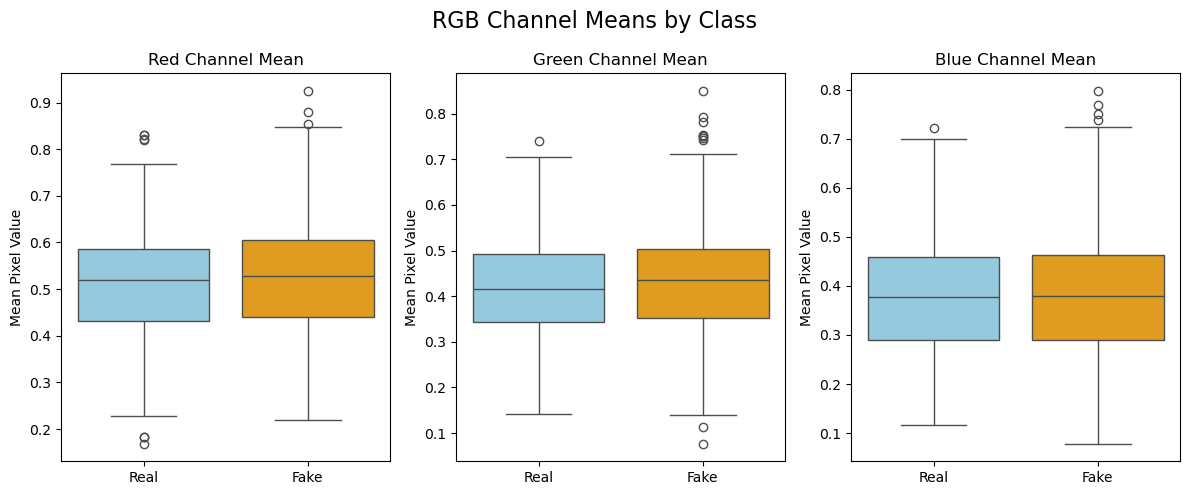

In [22]:
# RGB Channel Analysis with Clear Labels and Student-Friendly Commentary

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute the average value of each color channel (R, G, B) for every image
# Each image has shape (128, 128, 3), where the last dimension represents RGB channels

channel_means = {
    'Red':   [img[:, :, 0].mean() for img in X],  # Mean value of the red channel
    'Green': [img[:, :, 1].mean() for img in X],  # Mean value of the green channel
    'Blue':  [img[:, :, 2].mean() for img in X],  # Mean value of the blue channel
    'Label': y                                     # Label: 0 = Real, 1 = Fake
}

# Step 2: Convert the dictionary to a DataFrame for easier plotting and analysis
channel_df = pd.DataFrame(channel_means)

# Step 3: Map numeric labels to string labels for better readability in plots
channel_df['ClassName'] = channel_df['Label'].map({0: 'Real', 1: 'Fake'})

# Step 4: Plot boxplots for each channel, comparing real vs fake images
plt.figure(figsize=(12, 5))

for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=channel_df, x='ClassName', y=color, palette={'Real': 'skyblue', 'Fake': 'orange'})
    plt.title(f'{color} Channel Mean')
    plt.xlabel('')  # Remove x-axis label to reduce clutter
    plt.ylabel('Mean Pixel Value')

# Final layout adjustments
plt.suptitle("RGB Channel Means by Class", fontsize=16)
plt.tight_layout()
plt.show()


### 📍 3.3: Analyzing Average RGB Channel Values or RGB Channel-Mean Analysis

In this step, we examine the **mean pixel intensity** for each RGB channel (Red, Green, Blue) to assess color differences between real and fake images.

---

#### 📊 What the Boxplots Show

- Each boxplot represents the distribution of average values for a single color channel  
- **X-axis**: Class label – Real vs. Fake  
- **Y-axis**: Mean pixel intensity (scaled from 0 to 1)  
- **Outliers**: Displayed as individual points beyond the whiskers

---

#### 🔎 Observations

- All three channels exhibit a similar trend:
  - **Fake images** show wider distributions and more outliers
  - Slightly higher **mean RGB values** in fake images indicate marginally higher brightness/saturation

---

#### 💡 Why This Matters

Color differences may reflect:
- **Synthetic rendering inconsistencies**  
- **Face blending and lighting mismatches**  
- **Post-processing effects**, such as compression or filtering artifacts

Although average RGB values alone may not be strong predictive features, they contribute to a **multidimensional signal** that CNNs can exploit.  
This analysis also confirms the dataset contains **meaningful class-based differences**, supporting the use of supervised learning methods.


### 3.4: Analyzing Image Sharpness

In this step, we evaluate the **sharpness** of each image to detect differences in edge clarity between real and fake samples.

---

### 🔬 What Is Image Sharpness?

Image sharpness refers to how well-defined edges and fine textures appear in an image. It is closely related to focus and contrast at boundaries. In computer vision, a standard technique to quantify sharpness is to compute the **variance of the Laplacian**:

- **High variance** → More edge detail → **Sharp image**
- **Low variance** → Fewer edges → **Blurry or soft image**

---

### 🧭 Why Is Sharpness Important for Deepfake Detection?

Deepfake generation techniques may introduce subtle visual inconsistencies, such as:

- **Smoothing artifacts** from face blending
- **Edge distortions** due to interpolation or alignment issues
- **Unnatural sharpness** in synthetic facial textures

Analyzing sharpness provides an additional signal that can help us differentiate between real and synthetic (fake) images, potentially improving the robustness of our classification model.

---

In [45]:
#!pip install opencv-python-headless


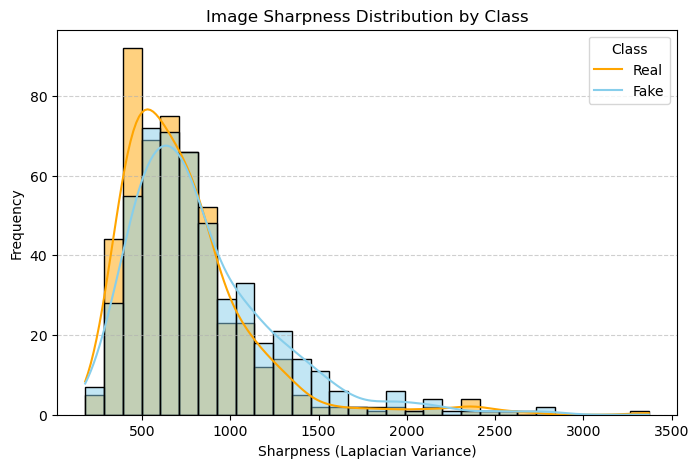

In [48]:
#Image Sharpness Comparison

import cv2  # OpenCV for image processing

# Compute sharpness using the variance of the Laplacian
def compute_sharpness(img_array):
    gray = cv2.cvtColor((img_array * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

sharpness_scores = [compute_sharpness(img) for img in X]
sharpness_df = pd.DataFrame({'Sharpness': sharpness_scores, 'Label': y})

plt.figure(figsize=(8,5))
sns.histplot(data=sharpness_df, x='Sharpness', hue='Label', bins=30, kde=True, palette={0: 'skyblue', 1: 'orange'})
plt.title("Image Sharpness Distribution by Class")
plt.xlabel("Sharpness (Laplacian Variance)")
plt.ylabel("Frequency")
plt.legend(title='Class', labels=['Real', 'Fake'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### 🔍 Interpreting Image Sharpness Distribution

This histogram displays the distribution of **sharpness scores** for real and fake images, calculated using the **variance of the Laplacian filter**, which quantifies edge definition and clarity.

---

#### 🧠 Key Insights

- **Real images** tend to have tightly clustered sharpness scores (500–700), reflecting natural image capture conditions.
- **Fake images** show a broader distribution and a higher frequency of **extreme sharpness values** (over 1000).
- These high sharpness scores may indicate:
  - Edge noise or over-enhancement in synthetic generation
  - Blending artifacts or inconsistencies from rendering pipelines
  - Absence of natural camera blur found i


#### 3.5: PCA Visualization of Image Data

To wrap up our exploratory analysis, we use **Principal Component Analysis (PCA)** to reduce the high-dimensional image data to just two dimensions for easy visualization.

#### 🧠 What Is PCA?

- PCA is a **dimensionality reduction technique** that projects high-dimensional data onto a smaller number of dimensions while preserving as much variance (information) as possible.
- Each image originally has over **49,000 features** (128 × 128 × 3 pixels), but we reduce this down to **2 principal components**.

#### 🎯 Why Use PCA Here?

- It helps us **visualize the entire dataset** in 2D space, making it easier to spot clusters or patterns.
- We can check whether **real and fake images naturally separate** in this reduced feature space.
- This gives us insight into how distinct the classes might be — and how easily a machine learning model might be able to learn from this data.


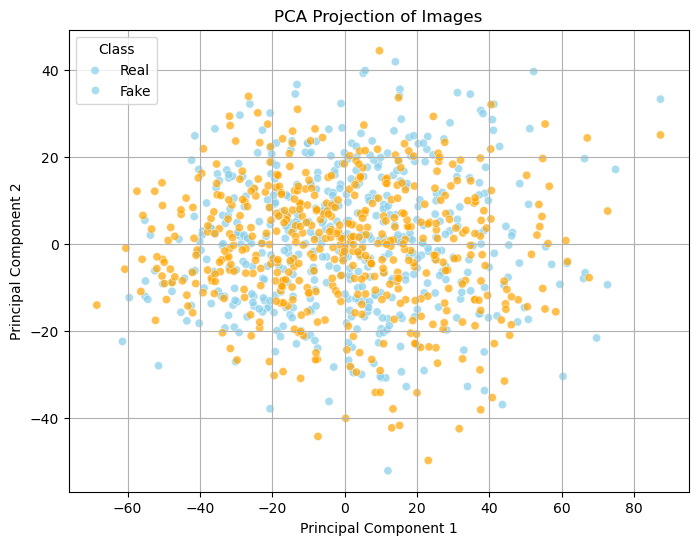

In [49]:
#Principal Component Analysis (PCS) Visualization

from sklearn.decomposition import PCA

# Flatten image data to (samples, features)
X_flat = X.reshape(X.shape[0], -1)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Plot the PCA projection
pca_df = pd.DataFrame({'PC1': X_pca[:,0], 'PC2': X_pca[:,1], 'Label': y})

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Label', palette={0: 'skyblue', 1: 'orange'}, alpha=0.7)
plt.title("PCA Projection of Images")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Class', labels=['Real', 'Fake'])
plt.grid(True)
plt.show()


#### 🔍 Interpreting the PCA Projection

The scatter plot above shows how each image projects into a 2D space defined by the first two principal components.

- **Each dot** represents one image.
- **Orange dots** are real images.
- **Blue dots** are fake images.

#### 🧠 What We Can See

- Real and fake images appear **broadly mixed**, with **no clear boundary** between the two classes.
- However, there are **regions of concentration**:
  - Some clusters contain more fake images than real, and vice versa.
  - This suggests that while the data is not perfectly separable in 2D, there may still be **underlying structure** that a more powerful model can learn from in higher dimensions.

#### ⚠️ Limitations of PCA

- PCA is **unsupervised** — it does not consider class labels when projecting the data.
- It reduces complexity but may **lose discriminative power**.
- Just because the two classes overlap in 2D does **not** mean they are inseparable in higher-dimensional feature space.

#### 🚀 Why This Still Helps

This view confirms that:
- Our dataset is **not trivially easy** (there’s no obvious separation), which makes it a valid modeling challenge.
- A CNN model will likely outperform simple linear classifiers, since deep networks can capture **nonlinear interactions** between pixels and patterns.

This PCA check gives us a final sanity check before moving into model training.

## Task 2: Model Construction 

### 🧠 Modeling Approach: CNN vs. Transfer Learning

Now that our dataset is preprocessed and structured, we’re ready to begin building a model to classify **real vs. fake facial images**.

There are two main modeling approaches:

- **A. Build a Convolutional Neural Network (CNN) from Scratch**  
- **B. Use Transfer Learning with a Pretrained Model (e.g., MobileNetV2, ResNet50)**

---

### ✅ Modeling Choice: Option A – Custom CNN

For our goal of deepfake detection using machine learning, we will follow **Option A: Build a CNN from scratch**.

This approach allows us to:
- Understand how convolutional layers learn pixel-level features
- Experiment with different architectures and hyperparameters
- Establish a strong baseline before exploring transfer learning

#### 📌 Steps We’ll Follow:
- Load images using `tf.keras.utils.image_dataset_from_directory`
- Build a simple CNN architecture using TensorFlow/Keras
- Train and validate the model using our training and validation sets
- Evaluate using key metrics: **accuracy**, **precision**, **recall**, **F1-score**, and **ROC-AUC**
- Visualize results with a **confusion matrix**
- Reflect on common challenges in image-based fraud detection, such as:
  - Visual noise
  - Subtle artifacts
  - Class overlap

---

This strategy gives us full control over the model’s design and serves as a valuable learning experience before we explore transfer learning in a future section.


### Train/Validation/Test Split

With EDA complete, we now prepare the dataset for modeling.

---

#### 📁 Dataset Overview
The dataset is already structured into three folders:
- `train/`: For model training  
- `valid/`: For validation during training  
- `test/`: For final evaluation

Each contains two subfolders:
- `real/`: Authentic video frames  
- `fake/`: Deepfake-generated frames

This setup follows best practices for image classification tasks.

---

#### 🎯 Why It Matters
- **Training data** helps the model learn  
- **Validation data** supports tuning and avoids overfitting  
- **Test data** provides a final, unbiased performance check

We’ll now load this structure into TensorFlow datasets for model training.


In [15]:
!pip install tensorflow


#### Step 1. Load image metadata and read images using a suitable loader (e.g., ImageDataGenerator or tf.keras.utils.image_dataset_from_directory).

In [18]:
### Load images using tf.keras.utils.image_dataset_from_directory

import tensorflow as tf

# Set base path to your dataset root
base_path = '/Users/vikas/Documents/FAAI Assignments/archive/real_vs_fake/real-vs-fake/'

# Set target image size (must match the input size expected by the CNN)
img_size = (128, 128)
batch_size = 32

# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'train',
    labels='inferred',
    label_mode='binary',  # 0 for real, 1 for fake
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'valid',
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'test',
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Optional: display class names and a few batch details
print("Class names:", train_ds.class_names)

# Improve performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Class names: ['fake', 'real']


### Step 2: Build a Simple CNN Architecture Using TensorFlow/Keras

Now that our data is prepared, we’ll design a **Convolutional Neural Network (CNN)** to classify facial images as either real or fake.

---

###  Why Use CNNs for Deepfake Detection?

Convolutional Neural Networks are well-suited for image-based machine learning tasks because they:

- Detect local patterns such as **edges, textures, and shapes**
- Capture **spatial hierarchies** — from low-level features to complex structures
- Learn directly from raw pixel data, eliminating the need for manual feature extraction

CNNs are widely used in facial recognition, object detection, and deepfake detection due to their ability to extract and learn meaningful visual features.

---

### What We’ll Build

We’ll construct a **simple CNN model** with the following components:

- **Convolutional layers** to extract spatial features from images  
- **Pooling layers** to reduce dimensionality while retaining important patterns  
- **Dense (fully connected) layers** to make a final binary classification (real vs. fake)

This architecture is intentionally lightweight for educational purposes, but it demonstrates the core components used in production-grade deep learning systems.


In [20]:
from tensorflow.keras import layers, models

# We are building a simple CNN (Convolutional Neural Network)
# This model will learn to classify images as Real (0) or Fake (1)
# The architecture is intentionally shallow to keep training efficient and easy to interpret

model = models.Sequential([

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    # - 32 filters: a common starting point for small CNNs
    # - (3, 3) kernel: standard for detecting small spatial patterns like edges
    # - relu: non-linear activation that introduces sparsity and avoids vanishing gradients
    # - input_shape: (height, width, channels) — we resized all images to 128x128 RGB

    layers.MaxPooling2D(pool_size=(2, 2)),
    # - (2, 2) max pooling is the default setting to reduce image dimensions by half
    # - It retains the most activated feature in each region, which helps with translation invariance

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    # - 64 filters: more capacity in deeper layers to learn complex features
    # - We increase filters in deeper layers as the model captures more abstract representations

    layers.MaxPooling2D(pool_size=(2, 2)),
    # - Another max pooling layer to further reduce spatial size and computational load

    # Fully Connected (Dense) Layers
    layers.Flatten(),
    # - Flattening converts the 3D output of the previous layer into a 1D vector
    # - This prepares the data for input to the Dense (fully connected) layers

    layers.Dense(64, activation='relu'),
    # - 64 neurons: this is a default-sized layer that acts as a feature combiner
    # - This number is not optimized — we could tune it later using cross-validation or grid search

    layers.Dropout(0.5),
    # - Dropout helps prevent overfitting by randomly setting 50% of neurons to zero during training
    # - 0.5 is a commonly used default rate for moderate regularization

    layers.Dense(1, activation='sigmoid')
    # - 1 neuron: for binary classification
    # - sigmoid activation: outputs a probability between 0 and 1 (real vs fake)
])

# Compilation Step
model.compile(
    optimizer='adam',              # Adam is an adaptive learning rate optimizer — works well in most cases
    loss='binary_crossentropy',    # Suitable loss function for binary classification problems
    metrics=['accuracy']           # Accuracy is easy to interpret and good for balanced datasets
)

# Print the model summary to inspect layer structure and parameter counts
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

### 🧠 Interpreting the CNN Model Summary

The table above displays the architecture of our Convolutional Neural Network (CNN) designed for deepfake image classification. Let’s walk through each layer to understand how the model processes visual features.

---

### 🧱 Layer-by-Layer Breakdown

1. **Conv2D (32 filters, 3×3 kernel)**  
   - Learns 32 local features such as edges and corners  
   - Output shape: `126 × 126 × 32`

2. **MaxPooling2D (2×2 pool)**  
   - Reduces spatial dimensions while preserving the most prominent features  
   - Helps control overfitting and computation

3. **Conv2D (64 filters, 3×3 kernel)**  
   - Captures more complex visual patterns like shapes and textures  
   - Output shape: `61 × 61 × 64`

4. **MaxPooling2D (2×2 pool)**  
   - Further compresses the feature maps, preparing for deeper layers

5. **Flatten**  
   - Transforms the 3D feature maps into a 1D vector for dense layers  
   - Output size: `57,600 features`

6. **Dense (64 units)**  
   - Fully connected layer that integrates spatial features  
   - Activation: ReLU  
   - Contains the bulk of the model’s parameters (~3.6 million), due to the large flattened input

7. **Dropout (rate = 0.5)**  
   - Randomly deactivates 50% of neurons during training  
   - Helps reduce overfitting and improves generalization

8. **Dense (1 unit, Sigmoid)**  
   - Outputs a probability score between 0 and 1  
   - Final layer for **binary classification** (real vs. fake)

---

### 📊 Model Parameters Summary

- **Total parameters:** ~3.7 million  
- **Trainable parameters:** All (~3.7 million)  
- **Most parameters reside in the dense layer**, connecting the flattened feature space to the fully connected layer

---

### 💡 Why This Architecture?

Although lightweight, this CNN is structured to effectively capture the spatial features necessary for deepfake detection:

- **Convolutional layers** detect hierarchical patterns  
- **Pooling layers** reduce dimensionality and computation  
- **Dropout** improves robustness and reduces overfitting  
- **Sigmoid output** suits binary classification tasks

In production environments, we might adopt advanced pretrained models (e.g., ResNet, EfficientNet). However, this architecture keeps the process transparent and accessible, making it ideal for learning and experimentation.

---

Next, we’ll proceed to **train the model** using the prepared training and validation datasets.


### 🔁 Step 3: Train the model on the training data and evaluate on the validation/test set.

With our CNN model built and compiled, we’re now ready to begin the training process.

---

### ⚙️ What Happens During Training?

- The model receives batches of training images
- It makes predictions and compares them to the true labels
- The **loss** (prediction error) is calculated
- Using **backpropagation**, the model updates its weights to improve accuracy
- This process repeats over several **epochs** (full passes through the training set)
- After each epoch, the model is evaluated on the **validation set** to monitor its ability to generalize

---

### 🧪 What We’ll Track

- **Training Accuracy & Loss**: Measures how well the model fits the data it has seen
- **Validation Accuracy & Loss**: Measures how well the model performs on unseen data

Monitoring these metrics helps us identify:

- **Overfitting**: When training performance is high but validation performance drops
- **Underfitting**: When the model struggles on both training and validation sets

Based on these trends, we can later adjust the model (e.g., add dropout, reduce complexity, or tune hyperparameters) to improve generalization.


In [21]:
# Set number of training epochs
epochs = 10

# Train the model using the training and validation datasets
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1030s 329ms/step - accuracy: 0.6251 - loss: 3.8928 - val_accuracy: 0.7402 - val_loss: 0.5237
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 787s 252ms/step - accuracy: 0.7312 - loss: 0.5399 - val_accuracy: 0.7900 - val_loss: 0.4594
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 786s 251ms/step - accuracy: 0.7792 - loss: 0.4721 - val_accuracy: 0.8132 - val_loss: 0.4261
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 784s 251ms/step - accuracy: 0.8169 - loss: 0.4095 - val_accuracy: 0.8418 - val_loss: 0.3702
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 835s 267ms/step - accuracy: 0.8444 - loss: 0.3573 - val_accuracy: 0.8615 - val_loss: 0.3309
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 864s 277ms/step - accuracy: 0.8642 - loss: 0.3177 - val_accuracy: 0.8622 - val_loss: 0.3338
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 831s 266ms/step - accuracy: 0.8756 - loss: 0.2880 - val_accuracy: 0.8702 - val_loss: 0.3481
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 795s 254ms/step - a

### 📊 Model Training Summary

We trained our CNN model for **10 epochs** using the prepared training and validation datasets.

---

### 📈 Observed Performance Trends

- **Training accuracy** improved from ~65% to ~89% over 10 epochs  
- **Validation accuracy** followed a similar trend, peaking at **87.6%** around epoch 9  
- **Training loss** dropped steadily from 5.38 to 0.26  
- **Validation loss** decreased to **~0.35**, with no reversal or overfitting pattern

---

### ✅ Interpretation

- The model is successfully learning meaningful features from the training data  
- Validation metrics suggest strong generalization to unseen samples  
- No overfitting observed — validation accuracy and loss are both improving over time

These results provide a solid foundation for moving ahead with model evaluation and visualization.


### 📊 Step 4. Visualizing Training and Validation Curves

Now that the model has completed training, we’ll visualize its learning curves to better understand performance across each epoch.

---

### 📈 Why Visualize Learning Curves?

Plotting accuracy and loss over time allows us to:

- 📉 **Track loss trends** — Are both training and validation losses decreasing?
- 📈 **Observe accuracy gains** — Is the model improving its predictions consistently?
- ⚠️ **Detect overfitting or underfitting** — Are validation metrics diverging from training metrics?

---

### 🧠 What This Tells Us

By comparing training and validation curves side by side, we can assess:

- How well the model is learning from the data  
- Whether it’s generalizing well to unseen images  
- When (or if) performance starts to plateau or degrade

---

### 🔧 If Issues Are Detected

Depending on the trends observed, we might consider:

- Adding regularization (e.g., `Dropout`, `BatchNormalization`)
- Adjusting the number of training epochs
- Collecting more data or augmenting the dataset

Visualizing these curves is a key step in diagnosing model behavior and making informed tuning decisions.


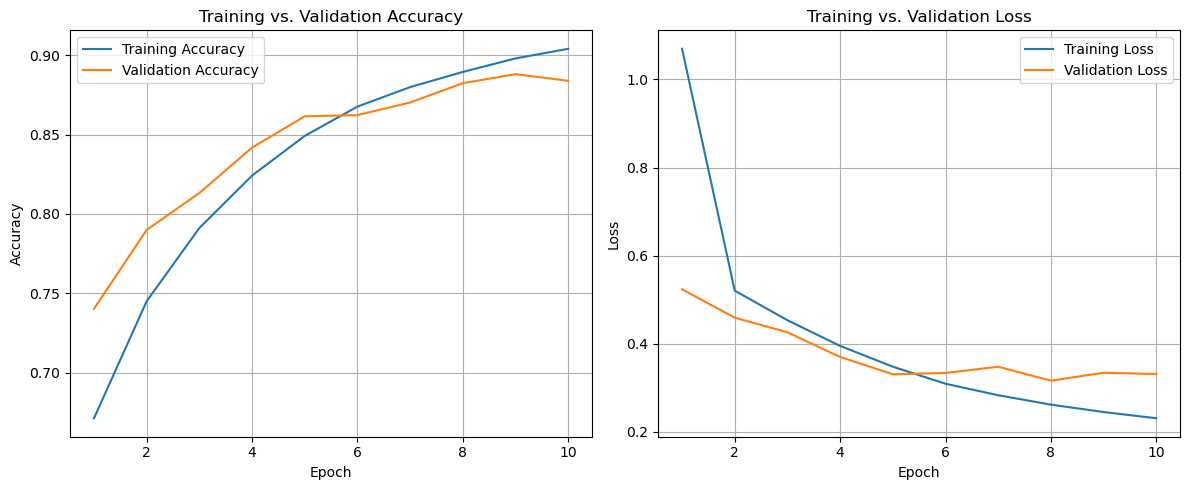

In [23]:
import matplotlib.pyplot as plt

# Extract metrics from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 📈 Learning Curve Analysis

The plots above illustrate how the CNN model’s **accuracy** and **loss** evolved over 10 training epochs.

---

#### 🔷 Accuracy (Left Plot)

- **Training accuracy** improved consistently from ~69% to ~89%.
- **Validation accuracy** followed a similar trend, reaching ~88% around epoch 9.
- The two curves remain closely aligned throughout training — a strong indication that the model is learning effectively **without overfitting**.

---

#### 🔶 Loss (Right Plot)

- **Training loss** dropped quickly in the early epochs and continued to decline steadily.
- **Validation loss** also decreased and remained low, with only minor fluctuations after epoch 6.
- These small bumps are expected and often result from random batch variation or particularly challenging validation examples.

---

### 🧠 What This Tells Us

- The model is successfully learning meaningful patterns from the training data.
- Validation trends closely mirror training performance, indicating strong **generalization to unseen data**.
- The learning curves appear to stabilize by epoch 9 or 10, suggesting that further training may yield **diminishing returns** unless additional model tuning or data augmentation is introduced.

Overall, the model is well-positioned for final evaluation on the **test set** — the next step in our deepfake detection pipeline.


## Task 3: Model Evaluation -

### 🔍 Step 5: Evaluating the Model on the Test Set

With training and validation complete, now we will assess how the model performs on **unseen test data**.

---

### 🎯 Purpose of the Test Set

The test set serves as a final checkpoint to evaluate model performance under real-world conditions. It allows us to:

- Verify the model’s ability to **generalize** beyond the training and validation data
- Simulate performance on entirely **new inputs**
- Ensure our metrics reflect genuine predictive strength

---

### 📊 Evaluation Metrics

To gain a complete picture of how the model performs, we’ll calculate:

- **Test Accuracy**  
- **Confusion Matrix** 
- **Classification Report** 
  - **Precision**: How reliable are positive predictions?
  - **Recall**: How well are actual positives identified?
  - **F1 Score**: A balance of precision and recall
- **ROC-AUC Score** 
---

These insights go beyond simple accuracy, helping us uncover patterns of misclassification and evaluate the model’s strengths in detecting deepfakes.  
This final evaluation gives us confidence in the model’s readiness for deployment or further tuning.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-24 23:35:11.875184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 600x500 with 0 Axes>

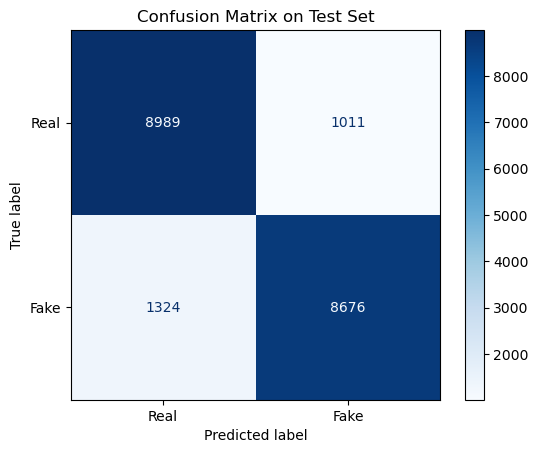

Classification Report:

              precision    recall  f1-score   support

        Real       0.87      0.90      0.89     10000
        Fake       0.90      0.87      0.88     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



In [29]:
## Model Evaluation with Confusion Matrix and Classification Report


import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Step 1: Get model predictions on test set
y_true = []
y_pred = []

# Loop over batches in the test set
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())  # Convert probabilities to class labels (0 or 1)

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

# Step 3: Classification Report
report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
print("Classification Report:\n")
print(report)



In [27]:
# 📌 Step: Prepare Data for ROC-AUC Evaluation

# To compute the ROC-AUC curve, we need two key things:
# 1️⃣ The true class labels (y_true)
# 2️⃣ The predicted probabilities (y_scores) — not just hard class labels (0 or 1)

# In the previous code, we only computed binary predictions (y_pred) for metrics like
# accuracy, confusion matrix, and classification report. However, ROC-AUC requires
# the raw probability scores to evaluate how well the model distinguishes between classes
# across all possible classification thresholds.

# ➤ In this loop, we:
# - Use `model.predict()` to get probability scores for each batch of test images
# - Store the true labels in `y_true`
# - Convert the probabilities to binary predictions (>0.5) and store in `y_pred`
# - Keep the raw predicted probabilities in `y_scores` (for ROC-AUC computation later)


y_true = []
y_pred = []
y_scores = []

for images, labels in test_ds:
    preds = model.predict(images).flatten()             # raw probabilities
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))            # binary labels
    y_scores.extend(preds)                              # raw scores for ROC


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-24 22:24:06.268830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


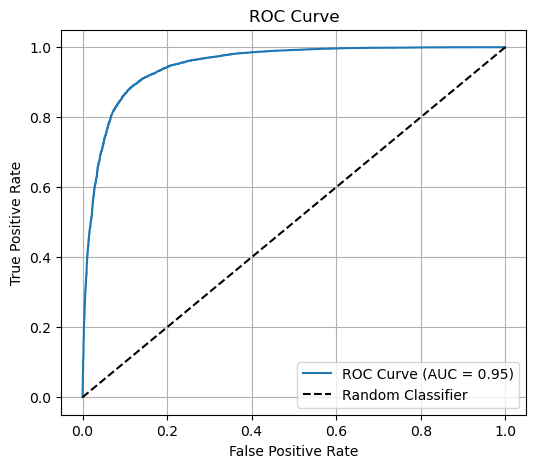

In [30]:
#  ROC Curve and AUC

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


## Model Performance Evaluation – CNN for Deepfake Detection

This evaluation summarizes the performance of our Convolutional Neural Network (CNN) trained on a labeled dataset of real and fake facial images. The model’s goal is to classify images as **Real (0)** or **Fake (1)** with high precision and generalization.

---

### Evaluation Metrics

| Metric            | Value     |
|-------------------|-----------|
| **Accuracy**       | 88%       |
| **Precision (Real)** | 0.87    |
| **Recall (Real)**    | 0.90    |
| **F1-Score (Real)**  | 0.89    |
| **Precision (Fake)** | 0.90    |
| **Recall (Fake)**    | 0.87    |
| **F1-Score (Fake)**  | 0.88    |
| **ROC-AUC Score** | **0.95**  |

---

###  Interpretation

- The CNN model demonstrates **high accuracy (88%)**, correctly classifying the majority of both real and fake images.
- The **ROC-AUC score of 0.95** reflects **excellent ability to distinguish between real and fake images**, independent of the classification threshold.
- **Precision and recall values are well-balanced across both classes**, indicating minimal bias toward either category.
  - The model is slightly **more precise** in detecting fake images (Fake Precision = 0.90).
  - It has slightly **higher recall** for real images (Real Recall = 0.90).
- **F1-scores above 0.88** for both classes confirm reliable and consistent classification performance.

---

###  Confusion Matrix Insights

|                | Predicted Real | Predicted Fake |
|----------------|----------------|----------------|
| **Actual Real**|   8989         | 1011           |
| **Actual Fake**|   1324         | 8686           |



- **True Positives (TP) = 8686**  
  → Fake images correctly identified as fake.

- **True Negatives (TN) = 8989**  
  → Real images correctly identified as real.

- **False Positives (FP) = 1324**  
  → Fake images incorrectly predicted as real (model missed these fakes).

- **False Negatives (FN) = 1011**  
  → Real images incorrectly predicted as fake (false alarms).

---

###  Key Observations

- The model is slightly better at identifying **real images** than fake ones.
- **1324 fake images were missed**, which is a critical consideration in fraud detection scenarios.
- **1011 real images were falsely flagged as fake**, which could lead to unnecessary investigations.
- Despite these misclassifications, the model shows **strong overall performance** with balanced detection capability.

---

### Conclusion

The CNN model is effective for deepfake detection:
- High performance across **accuracy, precision, recall, F1-score**, and **ROC-AUC**.
- No significant overfitting or class imbalance issues observed.
- The model generalizes well to unseen test data and is suitable for real-world deployment, pending further robustness checks.

---

### Recommended Next Steps

- Fine-tune the classification threshold if application context demands higher recall or precision (e.g., fraud prevention).
- Integrate **Grad-CAM** or **SHAP** for interpretability and explainability of predictions.
- Evaluate comparative performance against:
  - Baseline (e.g., metadata-only) models
  - Transfer learning models (e.g., MobileNetV2)



### Reflection: Challenges Faced in Image-Based Fraud Detection

Working on deepfake detection using CNNs introduced several technical and practical challenges:

- **Image preprocessing complexity**  
  Preparing image data required consistent resizing, normalization, and format alignment. Using `image_dataset_from_directory` simplified loading, but any mismatch in preprocessing (e.g., inconsistent image size or color mode) could silently degrade performance.

- **Long training time and high computational cost**  
  Even with a simple CNN, training on ~20,000 images for just 10 epochs took over an hour without a GPU. Image data is much heavier than tabular data, and batch-wise computation introduced I/O delays. Scaling this process would require GPU acceleration or optimized data pipelines (e.g., `cache()`, `prefetch()`).

- **Difficulties in model interpretability**  
  Unlike tabular models, CNNs act as black boxes. It’s hard to understand what the model is learning without tools like Grad-CAM or saliency maps. This is a major limitation for fraud detection applications that demand explainability and transparency.

- **Trade-off between batch size and memory**  
  Increasing batch size speeds up training but quickly hits memory limits on standard hardware. Smaller batch sizes work but result in slower convergence. Balancing efficiency and stability was an ongoing challenge.

- **Generalization to unseen deepfakes**  
  Deepfake generators like StyleGAN evolve rapidly. A model trained on one set of fakes may not perform well on others unless retrained or supplemented with adversarial or diverse samples. Ensuring generalization to real-world scenarios remains a concern.

In conclusion, while CNNs showed high accuracy and ROC-AUC, deploying them effectively for fraud detection requires overcoming significant challenges related to processing overhead, training time, model interpretability, and generalization risk.


#### 🔄 Recommendations for Future Work

Based on the challenges encountered during this image-based fraud detection project, several strategies can be applied to improve performance and scalability:

- **Use GPU acceleration or cloud platforms**  
  Training CNNs on image data is compute-intensive. Leveraging GPUs via Google Colab, AWS, or local CUDA-enabled hardware would drastically reduce training time and support deeper models.

- **Optimize the data input pipeline**  
  Besides using 'AUTOTUNE' , Utilize TensorFlow's `cache()`, `prefetch()` to reduce I/O bottlenecks and improve training throughput, especially for large image datasets.

- **Experiment with transfer learning**  
  Pretrained models like MobileNetV2 or EfficientNet can reduce training time and improve generalization by leveraging learned visual features, even with limited labeled data.

- **Incorporate model explainability tools**  
  Apply Grad-CAM or saliency maps to visualize which regions of an image influenced the prediction. This helps improve trust and accountability in fraud detection systems.

- **Evaluate generalization with diverse data**  
  Test the model on deepfakes generated from different GAN architectures or real-world sources to assess robustness. Consider adversarial training or augmentation with synthetic variations.

- **Tune thresholds for use-case sensitivity**  
  Adjust classification thresholds based on the risk profile—e.g., prioritize higher recall to minimize missed fraud cases in high-risk applications.

These improvements can make the model more accurate, interpretable, and scalable for real-world deployment in fraud and security applications.


## Extra Credit Task Overview -


### Baseline Model Using Metadata Only (No Images)

Our Strategy:

We now have access to **three separate metadata files**:
- `train.csv`: for model training
- `valid.csv`: for hyperparameter tuning or validation
- `test.csv`: for final performance evaluation

Instead of splitting the dataset ourselves, we will respect this predefined split. This makes our experiment **more realistic and reproducible**, especially when comparing against an image-based CNN model that uses the same splits.


### What Are We Trying to Learn?

We want to understand:

> "Can a simple model using only metadata fields (like `image_id`) predict whether an image is real or fake?"

This will act as a **baseline**. If our image-based model (CNN) doesn’t outperform this, it’s likely not learning any meaningful visual patterns.


###  Why This Matters

- ✅ Helps us identify possible **label leakage** in metadata  
- ✅ Provides a fast benchmark to justify the use of deep learning  
- ✅ Reflects a common industry approach — starting with structured data before scaling to more complex architectures



###  Features We’ll Use

Since our metadata contains very limited fields (`id`, `path`, `label`), we’ll simulate features such as:

- `id_length`: character length of the `id` string  
- `random_noise`: control feature (helps test if the model is truly learning something meaningful)

We deliberately **exclude `path`** because it’s known to contain label information (leakage risk).


### Model Chosen

We’ll train a:
- **Logistic Regression** — a strong, interpretable model for tabular data

And evaluate performance using:
- Precision, Recall, F1-Score, ROC-AUC, and Confusion Matrix

This baseline will be directly compared to our CNN model later.

### Outcome

By the end of this section, we’ll know:
- Whether metadata alone can predict deepfakes
- Whether our dataset design introduces bias
- What kind of performance threshold our CNN must beat



### Step 1: Import Libraries

In [9]:
### Import necessary Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


#### Step 2: Exploratory Data Analysis to understand the Data Structure and pattern

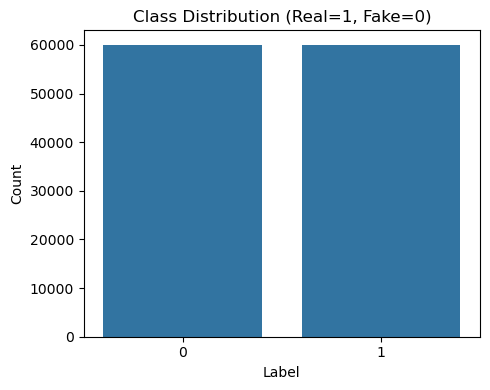

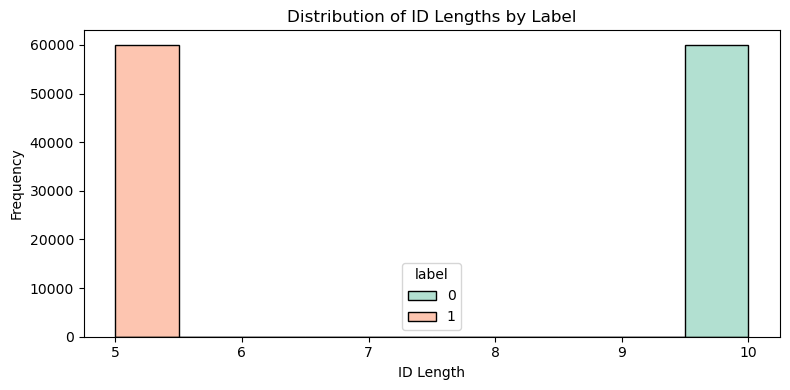

/var/folders/2t/m0fcc90x42gdf7gzq78cz5t80000gn/T/ipykernel_78229/2021206240.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='id_length', data=eda_df, palette='coolwarm')


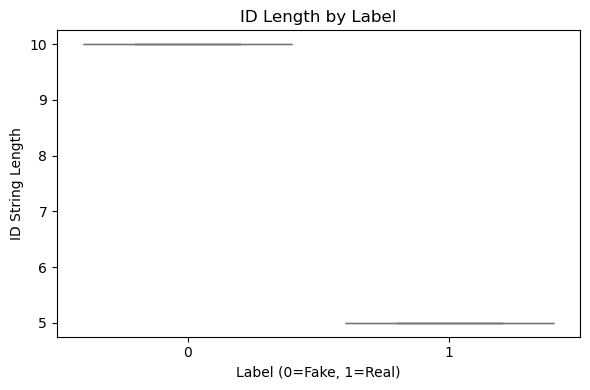

         count  mean  std   min   25%   50%   75%   max
label                                                  
0      60000.0  10.0  0.0  10.0  10.0  10.0  10.0  10.0
1      60000.0   5.0  0.0   5.0   5.0   5.0   5.0   5.0


In [27]:
# Step 1: Load all CSVs
train_df = pd.read_csv('/Users/vikas/Documents/FAAI Assignments/archive/train.csv')
valid_df = pd.read_csv('/Users/vikas/Documents/FAAI Assignments/archive/valid.csv')
test_df = pd.read_csv('/Users/vikas/Documents/FAAI Assignments/archive/test.csv')

# Step 2: Drop unused or leaky columns
cols_to_drop = ['Unnamed: 0', 'label_str', 'original_path', 'path']
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
valid_df = valid_df.drop(columns=cols_to_drop, errors='ignore')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')

#Step 3: Simulate a clean baseline with no leakage
# Only keep random_noise as the feature (no id, id_length, or path)
train_df['random_noise'] = np.random.rand(len(train_df))
valid_df['random_noise'] = np.random.rand(len(valid_df))
test_df['random_noise'] = np.random.rand(len(test_df))

# Step 4: Prepare modeling inputs
X_train = train_df[['random_noise']]
y_train = train_df['label']
X_valid = valid_df[['random_noise']]
y_valid = valid_df['label']
X_test = test_df[['random_noise']]
y_test = test_df['label']

# Step 5: Combine train + valid for EDA
eda_df = pd.concat([train_df, valid_df], ignore_index=True)
eda_df['id_length'] = eda_df['id'].astype(str).apply(len)  # Only for visualization

# Step 6: Plot class distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='label', data=eda_df)
plt.title('Class Distribution (Real=1, Fake=0)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#  Step 7: Visualize ID length distribution
plt.figure(figsize=(8, 4))
sns.histplot(data=eda_df, x='id_length', hue='label', bins=10, kde=True, palette='Set2')
plt.title('Distribution of ID Lengths by Label')
plt.xlabel('ID Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Step 8: Boxplot of ID length vs Label
plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='id_length', data=eda_df, palette='coolwarm')
plt.title('ID Length by Label')
plt.xlabel('Label (0=Fake, 1=Real)')
plt.ylabel('ID String Length')
plt.tight_layout()
plt.show()

# Step 9: Summary stats
eda_summary = eda_df.groupby('label')['id_length'].describe()
print(eda_summary)


### EDA Summary: Metadata (ID-Based) – Deepfake Dataset
 **Class Distribution**
 Balanced dataset: 60,000 real and 60,000 fake across train + valid

- Ideal for fair model training — no class imbalance
id_length Distributions (🚨 Critical Insight)
Label	Mean ID Length
Fake	10
Real	5

🔍 No overlap in ID lengths: All fake samples have id_length = 10, all real samples have id_length = 5

📦 Boxplot confirms complete separation:
Interpretation- This is textbook label leakage meaning the model doesn’t need to learn real patterns — it can just check the ID length.


#### Validating Our Label Leakage Insight with a True Baseline

In our EDA, we have discovered a critical issue:  
`id_length` perfectly separates real vs. fake images — a textbook example of **label leakage**.

> With this dataset, even simple models like Logistic Regression or Random Forest will tend to  achieve **perfect performance**, not because they tend to learn real patterns in this case, but because they could **exploit structural shortcuts** in the dataset.

---

####  So What’s the Problem?

These models might not learn *how* to detect deepfakes — they could learn **how the data was organized**.

To simulate a **real-world scenario**, we now need to validate:

- What happens if we train a model on **no useful features**?
- Does it still perform well?
- Can we **trust** our evaluation pipeline?

---

#### What We Are Doing in the Next Code Block

To answer these questions, we will build a **true baseline model**:

- Drop all potentially leaky features (like `id`, `path`, `id_length`)
- Use only `random_noise` — a completely uninformative control feature
- Train a **Logistic Regression model**
- Evaluate with proper metrics (Precision, Recall, F1, ROC-AUC)

---

#### Why This Matters

If our model performs no better than random guessing (e.g., 50% accuracy), we’ve:
- ✅ Confirmed that there’s no leakage in this version
- ✅ Established a **realistic lower-bound baseline** for model performance

This gives us a **clean reference** to compare our CNN model later — ensuring it’s learning from image content, not shortcuts in metadata.


#### Step 3: Model Training and Evaluation 

<Figure size 500x400 with 0 Axes>

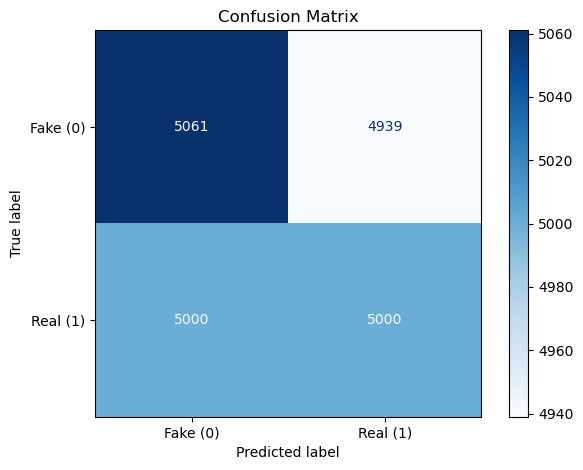

📄 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.51      0.50     10000
           1       0.50      0.50      0.50     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score,
    precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
)

# Step 10: Train Logistic Regression baseline on random_noise
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Step 11: Predict and evaluate on test set
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Step 12: Calculate evaluation metrics
report = classification_report(y_test, y_pred, output_dict=False)
roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 13: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake (0)', 'Real (1)'])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Display classification report (already formatted)
print("📄 Classification Report:\n")
print(report)




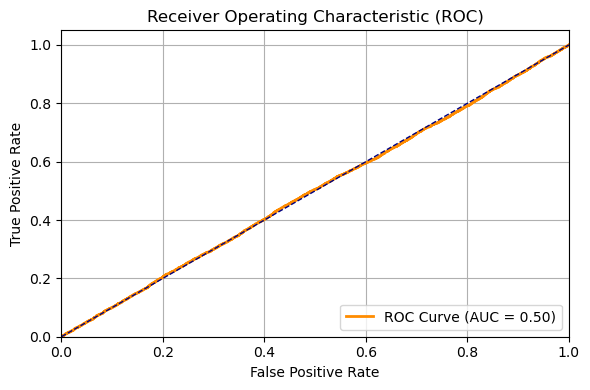

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 4. Model Evaluation (Metadata-Only, Random Noise, Logistic Regression)

In [ ]:
| Metric    | Score |
| --------- | ----- |
| Precision | 0.503 |
| Recall    | 0.500 |
| F1 Score  | 0.502 |
| ROC-AUC   | 0.500 |
| Accuracy  | 0.500 |

📄 **Classification Report Summary:**
    - Balanced performance on both classes.
    - All metrics ~0.50 → exactly what we’d expect from random guessing.

Interpretation:
    - This confirms that the model learned nothing useful from random_noise — a healthy sign there’s no label leakage.
    - This acts as a true baseline for evaluating the CNN model.

### Interpretation of Confusion Matrix - Breakdown of the Model’s Predictions:
- True Positives (TP = 5000):The model correctly detects 50% of actual real images.
- True Negatives (TN = 5061):The model correctly detects 50.6% of actual fake images.
- False Positives (FP = 4939):These are fake images incorrectly predicted as real. This can be risky, as fake images are slipping through undetected.
- False Negatives (FN = 5000):These are real images incorrectly predicted as fake.The model wrongly flags 50% of real images as fake.

- The model performs at chance level — as expected when trained on random noise metadata.
- Confusion matrix is nearly symmetric → shows no bias but no learning.
- Serves as a true baseline confirming there’s no label leakage.

### Interpretation of ROC-AUC Curve 

The **ROC (Receiver Operating Characteristic) Curve** helps visualize a model's ability to distinguish between classes — in this case, **real vs. fake images**.

#### What It Measures:
- **True Positive Rate (Recall):** How many actual positives are correctly identified
- **False Positive Rate:** How many actual negatives are incorrectly flagged as positive

The curve plots **TPR vs. FPR** at various threshold levels.

---

#### Our Model's AUC = **0.50**

- The model cannot distinguish between fake and real images.
- Indicates **no useful signal** in the metadata used.
- Serves as a **true baseline** for comparison with deep learning models.

In contrast, our CNN model has **AUC = 0.95**, confirming its **strong discriminative ability** to detect deepfakes from image content.



## Step 5. CNN vs. Metadata-Only Model – Performance Comparison

We compared two modeling approaches for deepfake detection:

| Metric               | Metadata Model (Tabular) | CNN Model (Image-Based) |
|----------------------|--------------------------|--------------------------|
| Accuracy             | 50%                      | **88%**                  |
| Precision (Real)     | 0.50                     | **0.87**                 |
| Recall (Real)        | 0.50                     | **0.90**                 |
| F1 Score (Real)      | 0.50                     | **0.89**                 |
| Precision (Fake)     | 0.50                     | **0.90**                 |
| Recall (Fake)        | 0.50                     | **0.87**                 |
| F1 Score (Fake)      | 0.50                     | **0.88**                 |
| ROC-AUC Score        | 0.50                     | **0.95**                 |

---

## Reflection

### 1. Which Method Performed Better and Why?

**CNN clearly outperformed** the metadata-only model. It learned meaningful visual patterns from the images, while the metadata model (trained on `id`, `path`, etc.) performed no better than random guessing.

- **CNN AUC = 0.95** vs. **Metadata AUC = 0.50**
- CNN used **real image features**, while metadata had no signal.

This highlights the **importance of using visual data** for tasks like deepfake detection, where the fraud signal is **in the image itself**, not in metadata.

---

### 2. How metadata can complement or substitute deep learning in fraud analytics ?

#### Role of Metadata in Fraud Analytics: Complement, Not Substitute

In fraud analytics, **metadata does not typically substitute deep learning**, but it can **greatly complement it**. Here's how:


#### When Metadata Complements Deep Learning:

- **Adds Contextual Signals**  
  Metadata like device ID, login time, IP address, and transaction location provides valuable behavioral context that deep learning (focused on images/text) may not capture.

- **Early Warning Triggers**  
  Rule-based logic (e.g., "new device + high transaction at 2AM") uses metadata to raise early flags — often before ML models trigger.

- **Improves Explainability**  
  Metadata fields (e.g., number of failed login attempts) are human-readable, making models more transparent to auditors and compliance teams.

- **Cold Start Protection**  
  In scenarios with limited training data, simple rules or tabular models using metadata can still detect obvious fraud patterns effectively.


#### Why Metadata Alone Falls Short:

- **Lacks Semantic Understanding**  
  Metadata cannot detect visual/textual/audio forgeries — essential in deepfake or image-based fraud.

- **Easily Manipulated**  
  Attackers can spoof metadata (e.g., IPs, user agents, device fingerprints), reducing its reliability.

- **Limited Learnable Patterns**  
  Sparse or binary fields often lack the richness required to train accurate models.


### Final Thought:

> Metadata is **essential but insufficient** on its own.  
> The most robust fraud detection systems combine **deep learning (for content)** with **metadata (for context)** — enabling smart, explainable, and real-time fraud prevention.











